<a href="https://colab.research.google.com/github/hg0-7/NLP-Topic-Modeling/blob/main/NLP_Topic_Modeling_Corex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Husain Ghadiali

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
import nltk

In [ ]:
from google.colab import drive
import os
import ast

drive.mount('/content/drive')

folder_path = '/content/drive/My Drive/headlines'

df = pd.DataFrame()

for year in range(1999, 2025):
    for month in range(1, 13):
        file_name = f'{year}-{month}.csv'
        file_path = os.path.join(folder_path, file_name)
        if os.path.exists(file_path):
            data = pd.read_csv(file_path)


            data['keywords'] = data['keywords'].apply(lambda x: ' '.join(ast.literal_eval(x)) if isinstance(x, str) else ' '.join(x))

            data['merged'] = data['headline'] + ' ' + data['keywords']

            df = pd.concat([df, data], ignore_index=True)

print(df[['merged']].head())

Mounted at /content/drive
                                              merged
0                                     ART IN REVIEW 
1                                            Op-Art 
2                                         Key Rates 
3  In a Final Proposal, Players Make Concessions ...
4  Korea to Sell Control of Bank to U.S. Investor...


In [ ]:
df.head()

In [ ]:
df.drop(df.columns[[0,2,3,4,5]], axis=1, inplace = True)

In [ ]:
df.columns

Index(['pub_date', 'merged'], dtype='object')

In [ ]:
df['merged'].head()

In [ ]:
df['pub_date'].head()

In [ ]:
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import re

import nltk
nltk.download('stopwords')
nltk.download('wordnet')

In [ ]:
df['merged'] = df['merged'].astype(str)

nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_text(text):

    text = text.lower()

    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)

    tokens = text.split()

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords.words('english')]
    return ' '.join(tokens)

df['cleaned_text'] = df['merged'].apply(preprocess_text)


In [ ]:
df.to_csv('cleaned_text.csv', index=False)

In [ ]:
from google.colab import files
files.download('cleaned_text.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

To confirm that the data is being considered as one document on one row:

In [ ]:
df = pd.read_csv('cleaned_text.csv')

df['cleaned_text'] = df['cleaned_text'].astype(str)

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

X = vectorizer.fit_transform(df['cleaned_text'])

print(f"Shape of the document-term matrix: {X.shape}")
print(f"Number of rows in the DataFrame: {df.shape[0]}")

Shape of the document-term matrix: (2315906, 203844)
Number of rows in the DataFrame: 2315906


In [ ]:
vectorizer = CountVectorizer(max_df=1.0, min_df=2, stop_words='english')
X = vectorizer.fit_transform(df['cleaned_text'])
vocab = vectorizer.get_feature_names_out()
word2id = {word: idx for idx, word in enumerate(vocab)}

**Corex:**

In [ ]:
!pip install corextopic

In [ ]:
from corextopic import corextopic as ct
from corextopic import vis_topic as vt

In [ ]:
#To check if the following words exist in the corpus:

In [ ]:
seed_topic_list = {
    'Artificial Intelligence': ['ai', 'internet', 'machine', 'machine learning', 'neural networks', 'technology', 'robotics', 'deep learning', 'natural language processing', 'computer vision', 'automation', 'data', 'computers'],
    'Economy': ['recession', 'inflation', 'gdp', 'employment', 'unemployment', 'federal', 'fraud', 'stock market', 'stock', 'trade', 'interest', 'interest rate', 'fiscal', 'acquisition', 'earnings', 'financial'],
    'Healthcare': ['insurance', 'medicare', 'vaccine', 'biotech', 'fda', 'telemedicine', 'disease', 'diet', 'medicine', 'illness'],
    'Sports': ['olympics', 'fifa', 'nba', 'nfl', 'superbowl', 'athletics', 'doping', 'leaderboard', 'marathon', 'doping', 'score'],
    'Politics': ['elections', 'democrats', 'republicans', 'congress', 'white house', 'policy', 'campaign', 'senator', 'president', 'vote']
}


missing_seed_words = {topic: [word for word in words if word not in vocab]
                      for topic, words in seed_topic_list.items()}

for topic, missing_words in missing_seed_words.items():
    if missing_words:
        print(f"Missing seed words in '{topic}' topic: {', '.join(missing_words)}")
    else:
        print(f"All seed words in '{topic}' topic are present in the corpus.")

Missing seed words in 'Artificial Intelligence' topic: machine learning, neural networks, deep learning, natural language processing, computer vision, computers
Missing seed words in 'Economy' topic: stock market, interest, interest rate
All seed words in 'Healthcare' topic are present in the corpus.
All seed words in 'Sports' topic are present in the corpus.
Missing seed words in 'Politics' topic: elections, democrats, republicans, white house


In [ ]:
#Running the model with the finally decided seed words:

In [ ]:
seed_topic_list = {
    'Artificial Intelligence': ['ai', 'internet', 'machine', 'machine learning', 'neural networks', 'technology', 'robotics', 'deep learning', 'natural language processing', 'computer vision', 'automation', 'data', 'computers'],
    'Economy': ['recession', 'inflation', 'gdp', 'employment', 'unemployment', 'federal', 'fraud', 'stock market', 'stock', 'trade', 'interest', 'interest rate', 'fiscal', 'acquisition', 'earnings', 'financial'],
    'Healthcare': ['insurance', 'medicare', 'vaccine', 'biotech', 'fda', 'telemedicine', 'disease', 'diet', 'medicine', 'illness'],
    'Sports': ['olympics', 'fifa', 'nba', 'nfl', 'superbowl', 'athletics', 'doping', 'leaderboard', 'marathon', 'doping', 'score'],
    'Politics': ['elections', 'democrats', 'republicans', 'congress', 'white house', 'policy', 'campaign', 'senator', 'president', 'vote']
}

anchors = [[word for word in topic if word in vocab] for topic in seed_topic_list.values()]
anchor_strength = 3

model = ct.Corex(n_hidden=len(seed_topic_list), seed=1)
model = model.fit(X, words=vocab, anchors=anchors, anchor_strength=anchor_strength)

# Extract topics and print them
# After fitting the Corex model
topics = model.get_topics()
for n, topic in enumerate(topics):
    print(f"Topic {n}:")
    for item in topic:
        if isinstance(item, tuple) and len(item) == 3:
            word, weight, _ = item  # Ignore the third element
            print(f"\t{word}: {weight:.4f}")
        else:
            print(f"\tUnexpected item structure: {item}")

Topic 0:
	internet: 0.2737
	computer: 0.0980
	technology: 0.0626
	litigation: 0.0452
	suit: 0.0432
	data: 0.0263
	recording: 0.0212
	marketing: 0.0209
	advertising: 0.0184
	telephone: 0.0166
Topic 1:
	trade: 0.1857
	acquisition: 0.1118
	stock: 0.0929
	fraud: 0.0549
	financial: 0.0544
	federal: 0.0515
	divestiture: 0.0368
	merger: 0.0366
	airline: 0.0362
	airplane: 0.0358
Topic 2:
	medicine: 0.1137
	insurance: 0.0732
	health: 0.0609
	disease: 0.0422
	coronavirus: 0.0400
	ncov: 0.0381
	drug: 0.0293
	safety: 0.0293
	accident: 0.0261
	care: 0.0237
Topic 3:
	athletics: 0.0580
	baseball: 0.0462
	college: 0.0430
	football: 0.0414
	game: 0.0357
	basketball: 0.0356
	sport: 0.0308
	university: 0.0287
	nfl: 0.0165
	olympics: 0.0161
Topic 4:
	state: 0.1495
	united: 0.1480
	government: 0.1166
	politics: 0.1165
	election: 0.0854
	relation: 0.0547
	presidential: 0.0498
	defense: 0.0494
	international: 0.0435
	president: 0.0392


In [ ]:
df['year'] = pd.to_datetime(df['pub_date']).dt.year

In [ ]:
topic_assignments_df = pd.DataFrame(model.labels, columns=[f'Topic_{i}' for i in range(model.labels.shape[1])])

topic_assignments_df['Document'] = range(len(topic_assignments_df))

melted_assignments = topic_assignments_df.melt(id_vars=['Document'], var_name='Topic', value_name='Assigned')

assigned_topics = melted_assignments[melted_assignments['Assigned'] == 1]

In [ ]:
from itertools import combinations
from collections import Counter

topic_lists = topic_assignments_df.drop('Document', axis=1).apply(lambda row: row.index[row == 1].tolist(), axis=1)

co_occurrences = Counter(pair for doc_topics in topic_lists for pair in combinations(doc_topics, 2))

In [ ]:
binary_labels = model.labels

topic_assignments_df = pd.DataFrame(binary_labels, columns=[f'Topic_{i}' for i in range(binary_labels.shape[1])])

topic_assignments_df['year'] = df['year'].values

In [ ]:
topic_trends = topic_assignments_df.groupby('year').sum()

topic_trends_normalized = topic_trends.div(topic_trends.sum(axis=1), axis=0)

In [ ]:
topic_trends.head()

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4
year,,,,,
1999,8693,14993,9154,9731,19287
2000,10694,16064,9133,10456,21876
2001,10155,24624,10476,10389,27263
2002,10107,22204,11514,11468,26865
2003,10478,19438,12187,11208,28585


**Visualizations for temporal analysis of topics over the years:**

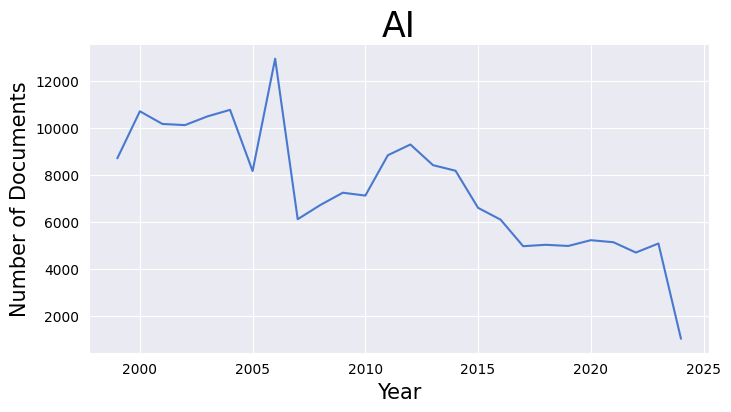

In [ ]:
# @title Artificial Intelligence

from matplotlib import pyplot as plt
topic_trends['Topic_0'].plot(kind='line', figsize=(8, 4))
plt.title('AI', fontsize=25, color='black')
plt.xlabel('Year', fontsize=15, color='black')
plt.ylabel('Number of Documents', fontsize=15, color='black')
plt.xticks(color='black')
plt.yticks(color='black')
plt.gca().spines[['top', 'right']].set_visible(False)

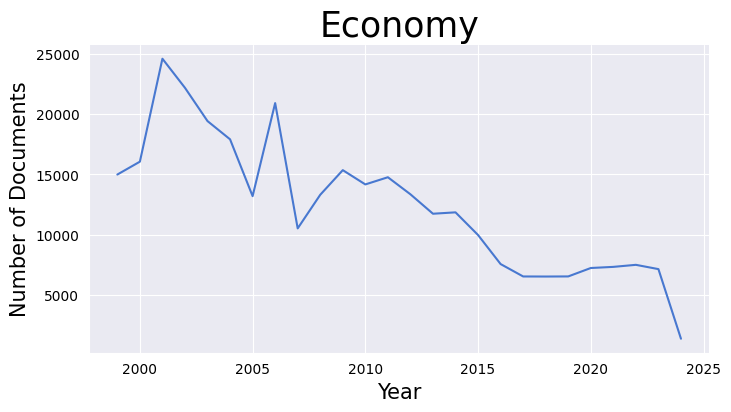

In [ ]:
# @title Economy

topic_trends['Topic_1'].plot(kind='line', figsize=(8, 4))
plt.title('Economy', fontsize=25, color='black')
plt.xlabel('Year', fontsize=15, color='black')
plt.ylabel('Number of Documents', fontsize=15, color='black')
plt.xticks(color='black')
plt.yticks(color='black')
plt.gca().spines[['top', 'right']].set_visible(False)

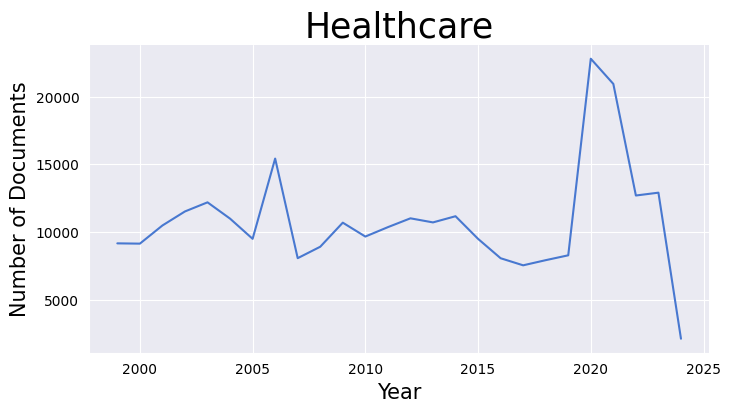

In [ ]:
# @title Healthcare

topic_trends['Topic_2'].plot(kind='line', figsize=(8, 4))
plt.title('Healthcare', fontsize=25, color='black')
plt.xlabel('Year', fontsize=15, color='black')
plt.ylabel('Number of Documents', fontsize=15, color='black')
plt.xticks(color='black')
plt.yticks(color='black')
plt.gca().spines[['top', 'right']].set_visible(False)

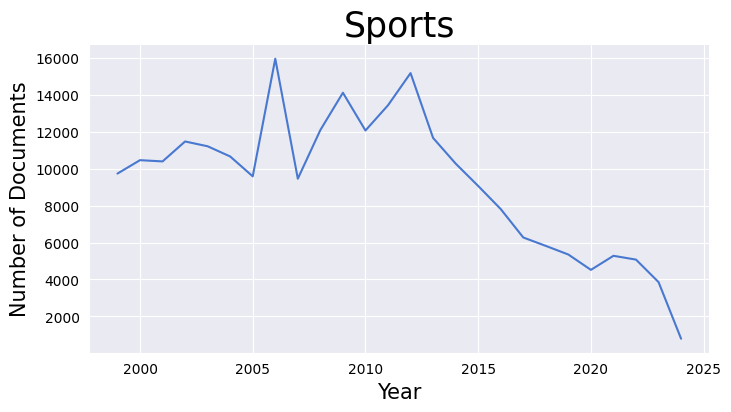

In [ ]:
# @title Sports

topic_trends['Topic_3'].plot(kind='line', figsize=(8, 4))
plt.title('Sports', fontsize=25, color='black')
plt.xlabel('Year', fontsize=15, color='black')
plt.ylabel('Number of Documents', fontsize=15, color='black')
plt.xticks(color='black')
plt.yticks(color='black')
plt.gca().spines[['top', 'right']].set_visible(False)

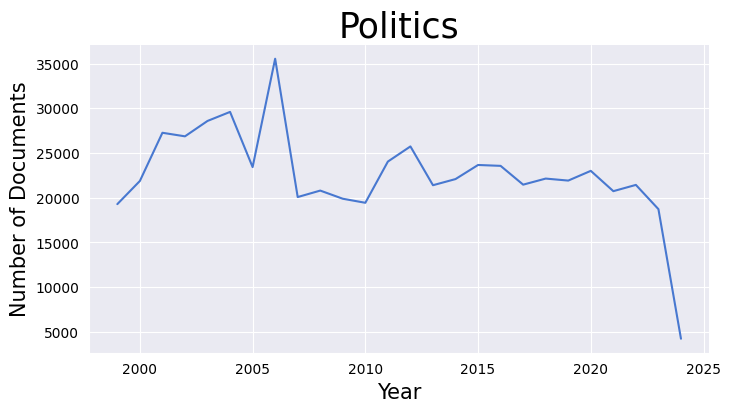

In [ ]:
# @title Politics

topic_trends['Topic_4'].plot(kind='line', figsize=(8, 4))
plt.title('Politics', fontsize=25, color='black')
plt.xlabel('Year', fontsize=15, color='black')
plt.ylabel('Number of Documents', fontsize=15, color='black')
plt.xticks(color='black')
plt.yticks(color='black')
plt.gca().spines[['top', 'right']].set_visible(False)

All the graphs show an upward trend around 2006. While it could be the data, upon my research, I found there to be a couple of potential reasons for this. Including rise in digital publications, social media sparked and a few other developments led to more news. This could potentilly be a reason.

Visualizations to analyze the temporal evolution of the topics over the years:

In [ ]:
topic_names = {
    'Topic_0': 'Artificial Intelligence',
    'Topic_1': 'Economics',
    'Topic_2': 'Healthcare',
    'Topic_3': 'Sports',
    'Topic_4': 'Politics',
}

In [ ]:
import plotly.express as px

fig = px.line(melted_topic_trends, x="year", y="Documents", color="Topic",
              title="Interactive Topic Trends Over Time",
              labels={"year": "Year", "Documents": "Number of Documents"})

topic_names = {
    "Topic_0": "Artificial Intelligence",
    "Topic_1": "Economy",
    "Topic_2": "Healthcare",
    "Topic_3": "Sports",
    "Topic_4": "Politics"
}

for trace in fig.data:
    if trace.name in topic_names:
        trace.name = topic_names[trace.name]

fig.show()

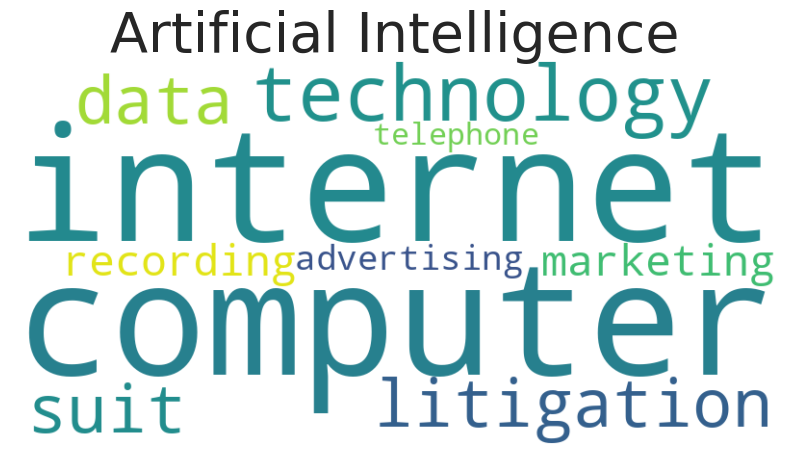

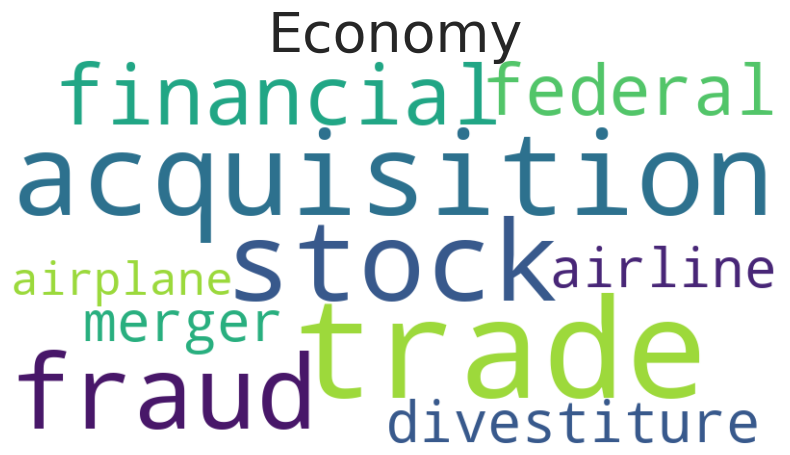

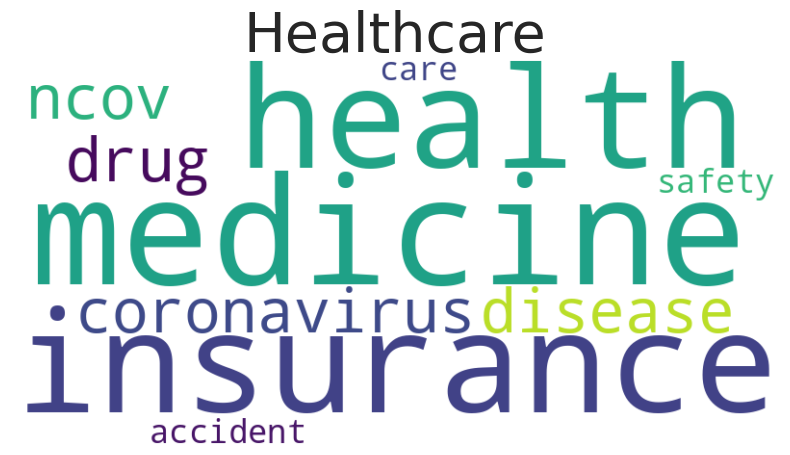

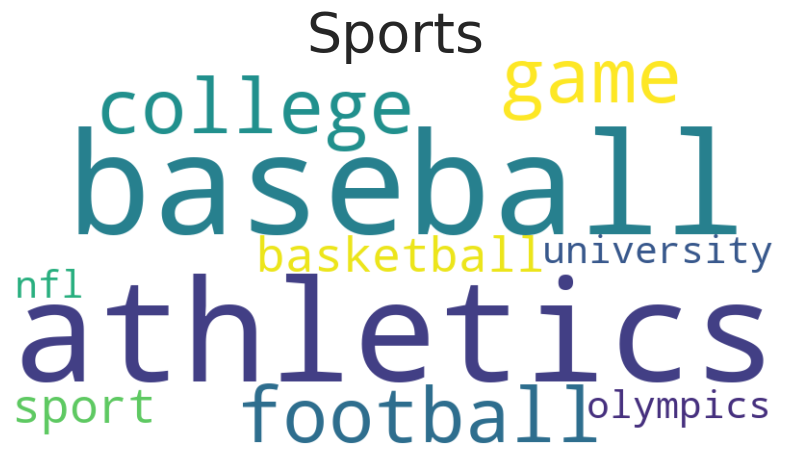

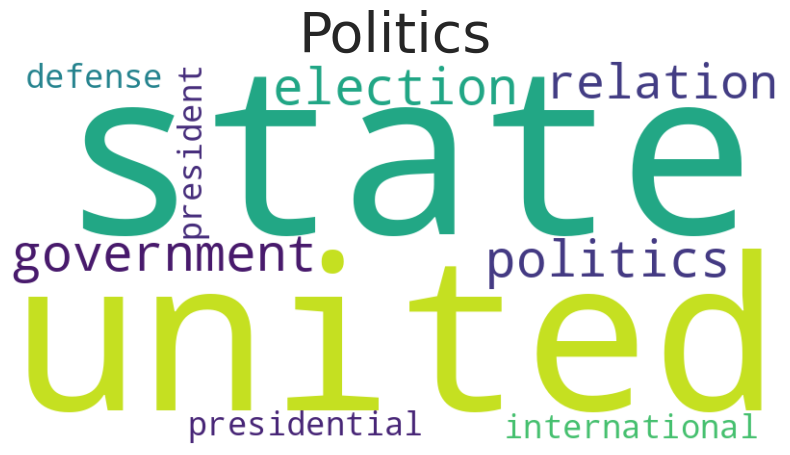

In [ ]:
from wordcloud import WordCloud

topic_labels = {0: "Artificial Intelligence", 1: "Economy", 2: "Healthcare",
                3: "Sports", 4: "Politics"}

for i, topic in enumerate(model.get_topics()):
    topic_words = [word for word, _, _ in topic]
    cloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(topic_words))

    plt.figure(figsize=(10, 5))
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'{topic_labels.get(i, f"Topic {i}")}', fontsize=40)
    plt.show()

**Unseeded corex model:**

In [ ]:
model_unseeded = ct.Corex(n_hidden=5, seed=42)

model_unseeded.fit(X)

vocab_array = np.array(vocab)

for i, topic_ngrams in enumerate(model_unseeded.get_topics(n_words=10)):

    topic_words = vocab_array[[ngram[0] for ngram in topic_ngrams if ngram[1] > 0]]
    print(f"Unseeded Topic {i}: {' '.join(topic_words)}")

NOTE: 'words' not provided to CorEx. Returning topics as lists of column indices
Unseeded Topic 0: united state government politics election presidential defense armament trump economy
Unseeded Topic 1: international relation terrorism law military world airline estate legislation airplane
Unseeded Topic 2: health coronavirus ncov medicine safety drug accident rate fare fee
Unseeded Topic 3: death paid notice engagement wedding obituary attempted murder dy appointment
Unseeded Topic 4: computer internet merger acquisition divestiture stock bond banking marketing advertising


In [ ]:
topics_unseeded = model_unseeded.get_topics()

NOTE: 'words' not provided to CorEx. Returning topics as lists of column indices


In [ ]:
print(topics_unseeded)

[[(99757, 0.20788387684986573, 1.0), (90816, 0.20778580942898606, 1.0), (38875, 0.16364932867793563, 1.0), (73280, 0.159939948250883, 1.0), (28172, 0.1155789442287718, 1.0), (74566, 0.06708206787173282, 1.0), (23021, 0.05122383398156274, 1.0), (4714, 0.038488405565469515, 1.0), (97985, 0.023869581334324673, 1.0), (27642, 0.023683344942340773, 1.0)], [(46899, 0.0696758838769945, 1.0), (78693, 0.06339335497823007, 1.0), (95149, 0.043897443032730424, 1.0), (53425, 0.03352723551788805, 1.0), (61305, 0.02956709431683232, 1.0), (105352, 0.028959957017657308, 1.0), (1657, 0.028321052768880674, 1.0), (29778, 0.027936891022375312, 1.0), (53859, 0.027666857665776323, 1.0), (1662, 0.02743009275636938, 1.0)], [(41941, 0.055592140204672416, 1.0), (19954, 0.037044495855031674, 1.0), (64731, 0.03494164439495277, 1.0), (59899, 0.034570645142872294, 1.0), (82317, 0.027567534698574016, 1.0), (26619, 0.027273210363816962, 1.0), (444, 0.024401866244549885, 1.0), (77211, 0.024203464970293253, 1.0), (31964,

In [ ]:
vocab_array = np.array(vocab)

for n, topic in enumerate(topics_unseeded):
    print(f"Unseeded Topic {n}:")
    topic_words_indices = [(tup[0], tup[1]) for tup in topic]
    topic_words = [vocab_array[index] for index, weight in topic_words_indices]
    print(", ".join([f"{word} ({weight:.4f})" for word, weight in zip(topic_words, [weight for index, weight in topic_words_indices])]))

Unseeded Topic 0:
united (0.2079), state (0.2078), government (0.1636), politics (0.1599), election (0.1156), presidential (0.0671), defense (0.0512), armament (0.0385), trump (0.0239), economy (0.0237)
Unseeded Topic 1:
international (0.0697), relation (0.0634), terrorism (0.0439), law (0.0335), military (0.0296), world (0.0290), airline (0.0283), estate (0.0279), legislation (0.0277), airplane (0.0274)
Unseeded Topic 2:
health (0.0556), coronavirus (0.0370), ncov (0.0349), medicine (0.0346), safety (0.0276), drug (0.0273), accident (0.0244), rate (0.0242), fare (0.0221), fee (0.0219)
Unseeded Topic 3:
death (0.1705), paid (0.1165), notice (0.1163), engagement (0.0377), wedding (0.0376), obituary (0.0366), attempted (0.0330), murder (0.0289), dy (0.0246), appointment (0.0206)
Unseeded Topic 4:
computer (0.0759), internet (0.0708), merger (0.0381), acquisition (0.0371), divestiture (0.0366), stock (0.0292), bond (0.0252), banking (0.0216), marketing (0.0201), advertising (0.0195)


In [ ]:
topics_dict = {}

for n, topic in enumerate(topics_unseeded):
    topic_words_indices = [(tup[0], tup[1]) for tup in topic]
    topic_words = [vocab_array[index] + f" ({weight:.4f})" for index, weight in topic_words_indices]
    topics_dict[f'Unseeded Topic {n}'] = topic_words

max_words = max(len(words) for words in topics_dict.values())

for topic, words in topics_dict.items():
    topics_dict[topic] = words + [''] * (max_words - len(words))

df_topics_horizontal = pd.DataFrame(topics_dict)

df_topics_horizontal

,Unseeded Topic 0,Unseeded Topic 1,Unseeded Topic 2,Unseeded Topic 3,Unseeded Topic 4
0,united (0.2079),international (0.0697),health (0.0556),death (0.1705),computer (0.0759)
1,state (0.2078),relation (0.0634),coronavirus (0.0370),paid (0.1165),internet (0.0708)
2,government (0.1636),terrorism (0.0439),ncov (0.0349),notice (0.1163),merger (0.0381)
3,politics (0.1599),law (0.0335),medicine (0.0346),engagement (0.0377),acquisition (0.0371)
4,election (0.1156),military (0.0296),safety (0.0276),wedding (0.0376),divestiture (0.0366)
5,presidential (0.0671),world (0.0290),drug (0.0273),obituary (0.0366),stock (0.0292)
6,defense (0.0512),airline (0.0283),accident (0.0244),attempted (0.0330),bond (0.0252)
7,armament (0.0385),estate (0.0279),rate (0.0242),murder (0.0289),banking (0.0216)
8,trump (0.0239),legislation (0.0277),fare (0.0221),dy (0.0246),marketing (0.0201)
9,economy (0.0237),airplane (0.0274),fee (0.0219),appointment (0.0206),advertising (0.0195)


We see some resemblance with the seeded corex topics here and we also see some distinction in themes for each category.

For topic 0 hinting towards politics, topic 1 having a broad economy theme, topic 2 strongly leaning towards healthcare, and topic 4 towards technology related terms at large.

**Thank you!**

**~Husain**